# Setup

In [1]:
import time

def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"\nTime: {round(end_time - start_time, 2)}s.\n")
        return result
    return wrapper

In [2]:
# %%writefile model/train.py
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix

from model.data_setup import create_dataloader
from model.engine import train
from model.utils import save_model
from model.model_builder import resnet50_model
from model.model_builder import resnet18_model
from model.model_builder import efficientnet_b3_model

import warnings
warnings.filterwarnings('ignore')

@timer
def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device != 'cpu':
        torch.cuda.empty_cache()
    print(f"Device: '{device}'")
    
    train_transforms_data = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(train_transform=train_transforms_data,
                                                                                      val_transform=val_transforms_data,
                                                                                      test_transform=test_transforms_data,
                                                                                      **kwargs)

    model, info_data = resnet18_model(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    
    loss_func = nn.CrossEntropyLoss()

    lr = kwargs['train_para']['optimize']['learning_rate']
    momentum = kwargs['train_para']['optimize']['momentum']
    weight_decay = kwargs['train_para']['optimize']['weight_decay']

    if kwargs['train_para']['optimize']['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(params= model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.SGD(params= model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(params= model.parameters(), lr= kwargs['train_para']['learning_rate'], weight_decay= 0.0001)
    
    accur = Accuracy(task='multiclass', num_classes= len(class_names)).to(device)

    step_size = kwargs['train_para']['lr_scheduler']['step_size']
    gamma = kwargs['train_para']['lr_scheduler']['gamma']
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size= step_size,
        gamma= gamma
    )

    epochs= kwargs['train_para']['epochs']
    save_checkpoint_freq= kwargs['train_para']['save_checkpoint_freq']
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            test_dataloader= test_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            lr_scheduler= lr_scheduler,
            mectric_funcs= accur,
            epochs= epochs,
            info_data = info_data,
            save_checkpoint_freq= save_checkpoint_freq,
            device= device,
    )
    
    save_model(model= model, results= results, class_names= class_names, device= device, **kwargs)

In [3]:
batch_size = 64

# Without batching (or extremely large)

## SGD

Device: 'cuda'
Epoch:  1 | Train Loss: 0.92059 | Train Acc: 58.6100 | Val Loss: 0.71442 | Val Acc: 74.5000
Epoch:  2 | Train Loss: 0.61409 | Train Acc: 82.3800 | Val Loss: 0.46250 | Val Acc: 88.1000
Epoch:  3 | Train Loss: 0.44918 | Train Acc: 89.2700 | Val Loss: 0.34113 | Val Acc: 93.6000
Epoch:  4 | Train Loss: 0.35427 | Train Acc: 92.7800 | Val Loss: 0.26161 | Val Acc: 95.2000
Epoch:  5 | Train Loss: 0.30683 | Train Acc: 92.4400 | Val Loss: 0.21439 | Val Acc: 96.4000
Epoch:  6 | Train Loss: 0.26193 | Train Acc: 93.9400 | Val Loss: 0.18797 | Val Acc: 96.3000
Epoch:  7 | Train Loss: 0.22469 | Train Acc: 94.7900 | Val Loss: 0.17391 | Val Acc: 97.0000
Epoch:  8 | Train Loss: 0.20008 | Train Acc: 95.5200 | Val Loss: 0.17153 | Val Acc: 97.2000
Epoch:  9 | Train Loss: 0.18215 | Train Acc: 95.9700 | Val Loss: 0.14359 | Val Acc: 97.6000
Epoch: 10 | Train Loss: 0.16809 | Train Acc: 96.0300 | Val Loss: 0.13611 | Val Acc: 97.8000



[INFO] Saving model to: runs\classify\train4

Time: 1598.91s.


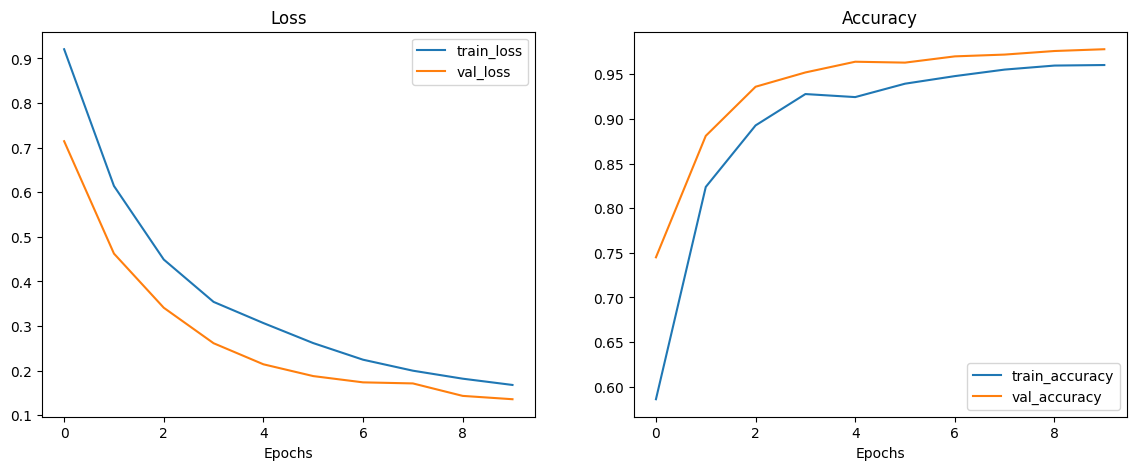

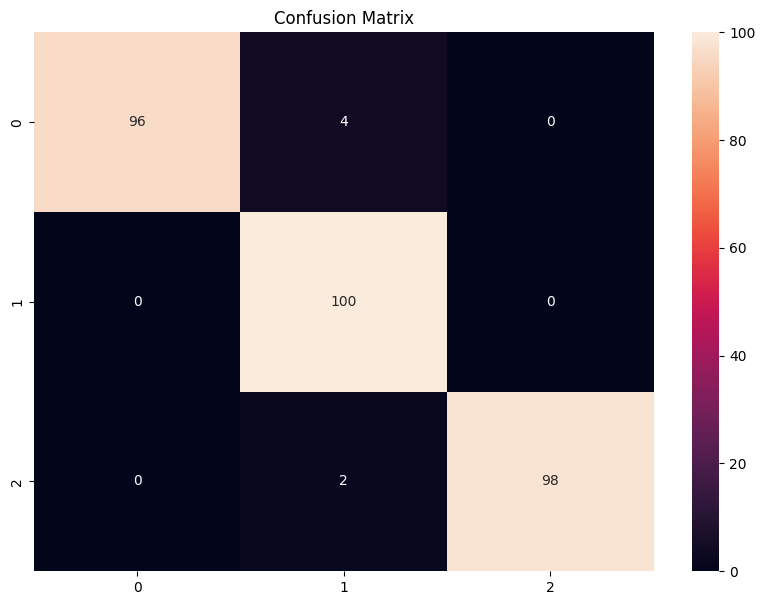

In [4]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': 500,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'sgd',
                'learning_rate': 0.01,
                'momentum': 0,
                'weight_decay': 0,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

## Adam

Device: 'cuda'
Epoch:  1 | Train Loss: 1.96245 | Train Acc: 42.6600 | Val Loss: 13033822.50000 | Val Acc: 20.0000
Epoch:  2 | Train Loss: 0.90912 | Train Acc: 52.4600 | Val Loss: 79153.62598 | Val Acc: 20.0000
Epoch:  3 | Train Loss: 0.68226 | Train Acc: 71.9800 | Val Loss: 14674.98071 | Val Acc: 21.1000
Epoch:  4 | Train Loss: 0.55685 | Train Acc: 77.4300 | Val Loss: 2082.63782 | Val Acc: 20.3000
Epoch:  5 | Train Loss: 0.48828 | Train Acc: 80.9300 | Val Loss: 264.78153 | Val Acc: 36.6000
Epoch:  6 | Train Loss: 0.44593 | Train Acc: 82.4400 | Val Loss: 29.08636 | Val Acc: 44.9000
Epoch:  7 | Train Loss: 0.41456 | Train Acc: 83.6500 | Val Loss: 5.00658 | Val Acc: 59.9000
Epoch:  8 | Train Loss: 0.35004 | Train Acc: 88.0900 | Val Loss: 1.45525 | Val Acc: 67.0000
Epoch:  9 | Train Loss: 0.26762 | Train Acc: 89.6500 | Val Loss: 0.42802 | Val Acc: 82.4000
Epoch: 10 | Train Loss: 0.24112 | Train Acc: 91.6900 | Val Loss: 0.13871 | Val Acc: 94.7000



[INFO] Saving model to: runs\classify\tra

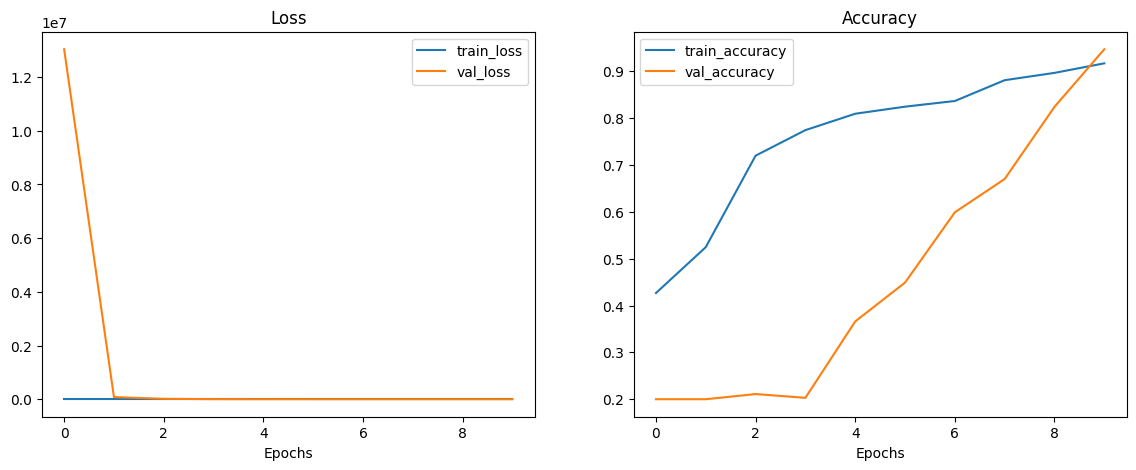

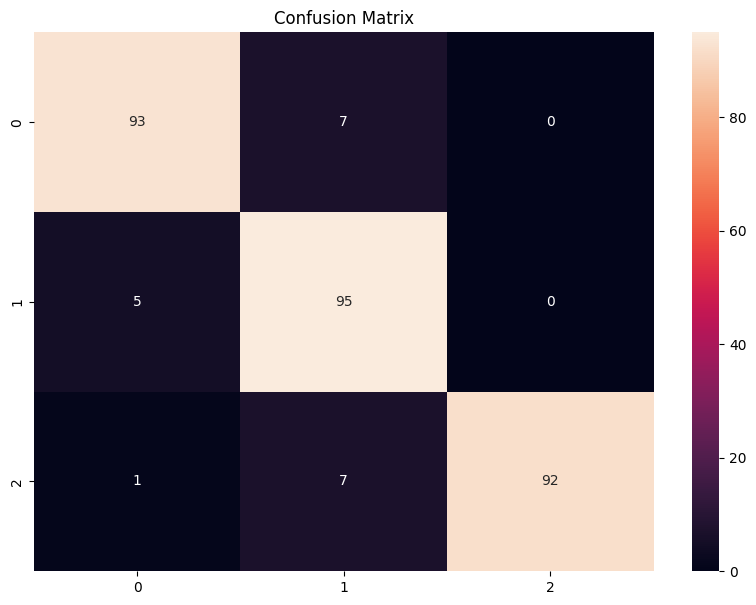

In [5]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': 500,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'adam',
                'learning_rate': 0.01,
                'momentum': 0,
                'weight_decay': 0,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

# With batching

## SGD

Device: 'cuda'
Epoch:  1 | Train Loss: 0.50166 | Train Acc: 82.9770 | Val Loss: 0.19156 | Val Acc: 96.0938
Epoch:  2 | Train Loss: 0.18566 | Train Acc: 94.7368 | Val Loss: 0.11002 | Val Acc: 98.1250
Epoch:  3 | Train Loss: 0.13044 | Train Acc: 96.0115 | Val Loss: 0.06573 | Val Acc: 98.9062
Epoch:  4 | Train Loss: 0.08893 | Train Acc: 97.6562 | Val Loss: 0.05016 | Val Acc: 98.9062
Epoch:  5 | Train Loss: 0.07288 | Train Acc: 98.0263 | Val Loss: 0.03754 | Val Acc: 99.5312
Epoch:  6 | Train Loss: 0.06429 | Train Acc: 98.1497 | Val Loss: 0.03019 | Val Acc: 99.5312
Epoch:  7 | Train Loss: 0.05711 | Train Acc: 98.3553 | Val Loss: 0.02526 | Val Acc: 99.6875
Epoch:  8 | Train Loss: 0.04888 | Train Acc: 98.3964 | Val Loss: 0.02166 | Val Acc: 99.6875
Epoch:  9 | Train Loss: 0.04116 | Train Acc: 98.7664 | Val Loss: 0.02140 | Val Acc: 99.5312
Epoch: 10 | Train Loss: 0.03895 | Train Acc: 98.7253 | Val Loss: 0.01681 | Val Acc: 99.8438



[INFO] Saving model to: runs\classify\train6

Time: 86.19s.



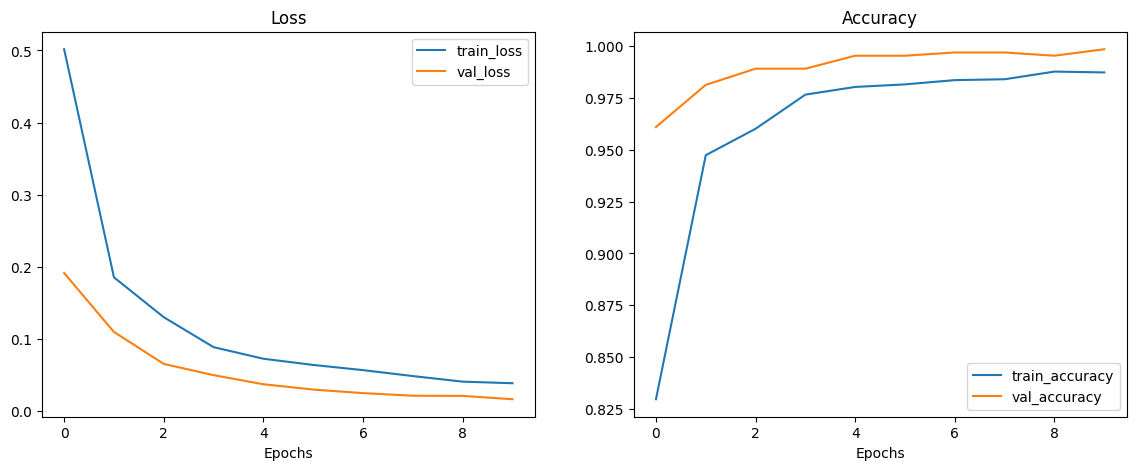

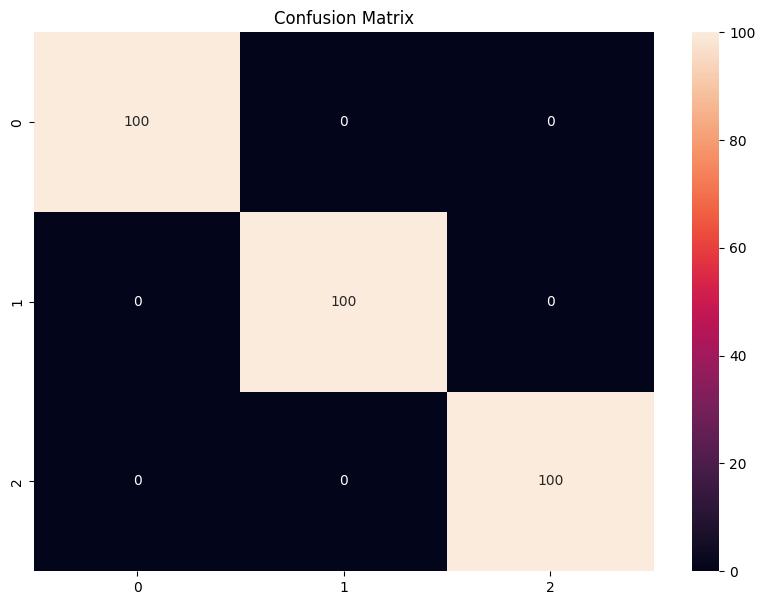

In [6]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': batch_size,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'sgd',
                'learning_rate': 0.01,
                'momentum': 0,
                'weight_decay': 0,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

## Adam

Device: 'cuda'
Epoch:  1 | Train Loss: 0.28977 | Train Acc: 88.2812 | Val Loss: 0.18307 | Val Acc: 95.0000
Epoch:  2 | Train Loss: 0.14678 | Train Acc: 95.3536 | Val Loss: 0.06792 | Val Acc: 97.5000
Epoch:  3 | Train Loss: 0.07534 | Train Acc: 97.4095 | Val Loss: 0.07289 | Val Acc: 97.5521
Epoch:  4 | Train Loss: 0.07831 | Train Acc: 97.2451 | Val Loss: 0.05476 | Val Acc: 98.1250
Epoch:  5 | Train Loss: 0.07213 | Train Acc: 97.1628 | Val Loss: 0.20383 | Val Acc: 94.2188
Epoch:  6 | Train Loss: 0.06814 | Train Acc: 97.3273 | Val Loss: 0.08655 | Val Acc: 97.5000
Epoch:  7 | Train Loss: 0.07084 | Train Acc: 97.9852 | Val Loss: 0.02490 | Val Acc: 99.3750
Epoch:  8 | Train Loss: 0.06598 | Train Acc: 97.7796 | Val Loss: 0.01986 | Val Acc: 99.3750
Epoch:  9 | Train Loss: 0.05543 | Train Acc: 98.3964 | Val Loss: 0.05369 | Val Acc: 98.1250
Epoch: 10 | Train Loss: 0.03582 | Train Acc: 98.9720 | Val Loss: 0.00575 | Val Acc: 99.8438



[INFO] Saving model to: runs\classify\train13

Time: 113.46s.


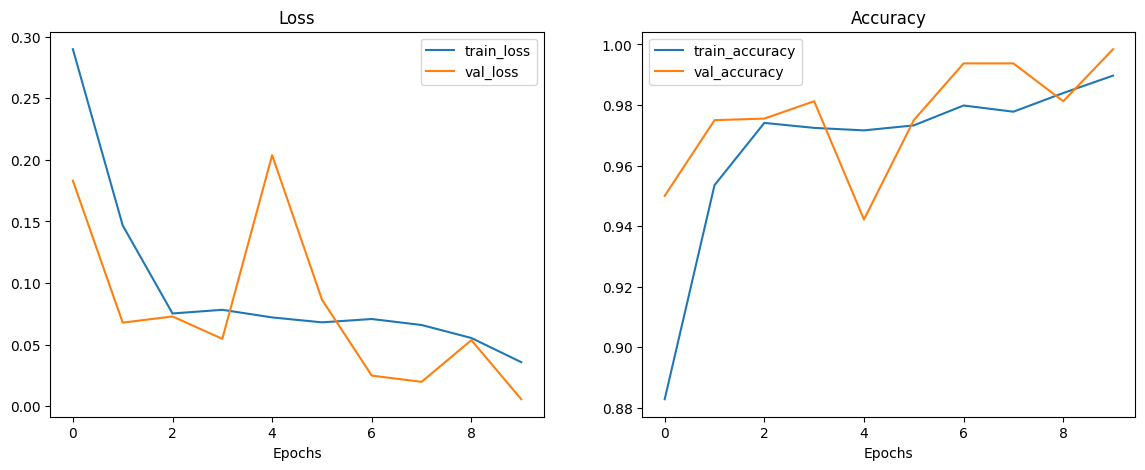

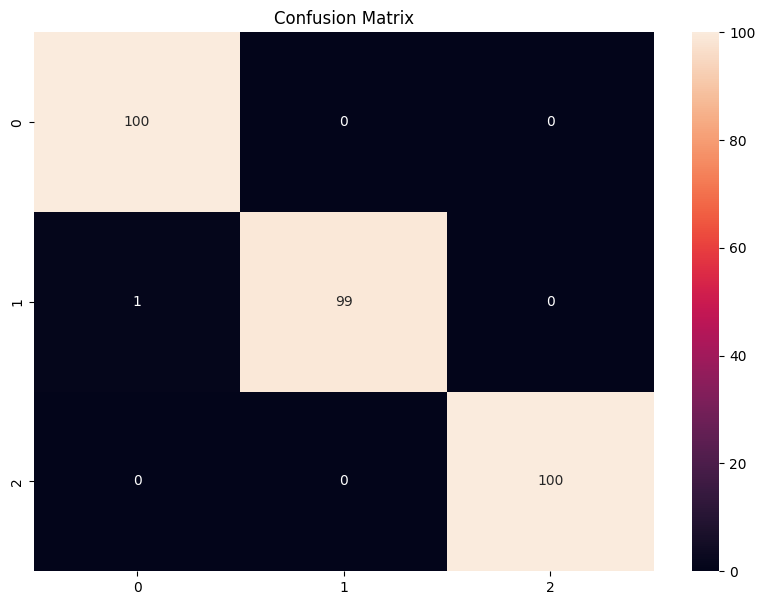

In [4]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': batch_size,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'adam',
                'learning_rate': 0.001,
                'momentum': 0,
                'weight_decay': 0,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

# With mometun (SGD only)

Device: 'cuda'
Epoch:  1 | Train Loss: 0.30217 | Train Acc: 86.5543 | Val Loss: 0.03724 | Val Acc: 98.9062
Epoch:  2 | Train Loss: 0.07803 | Train Acc: 96.9572 | Val Loss: 0.02004 | Val Acc: 99.3750
Epoch:  3 | Train Loss: 0.04823 | Train Acc: 98.1086 | Val Loss: 0.01469 | Val Acc: 99.8438
Epoch:  4 | Train Loss: 0.04210 | Train Acc: 98.6020 | Val Loss: 0.01029 | Val Acc: 99.6875
Epoch:  5 | Train Loss: 0.03792 | Train Acc: 98.6020 | Val Loss: 0.00586 | Val Acc: 100.0000
Epoch:  6 | Train Loss: 0.03561 | Train Acc: 98.9309 | Val Loss: 0.00664 | Val Acc: 99.8438
Epoch:  7 | Train Loss: 0.02849 | Train Acc: 98.8076 | Val Loss: 0.00383 | Val Acc: 100.0000
Epoch:  8 | Train Loss: 0.02830 | Train Acc: 99.0132 | Val Loss: 0.00631 | Val Acc: 99.8438
Epoch:  9 | Train Loss: 0.01982 | Train Acc: 99.3832 | Val Loss: 0.00646 | Val Acc: 99.6875
Epoch: 10 | Train Loss: 0.02804 | Train Acc: 99.0132 | Val Loss: 0.00379 | Val Acc: 100.0000



[INFO] Saving model to: runs\classify\train15

Time: 96.7s.

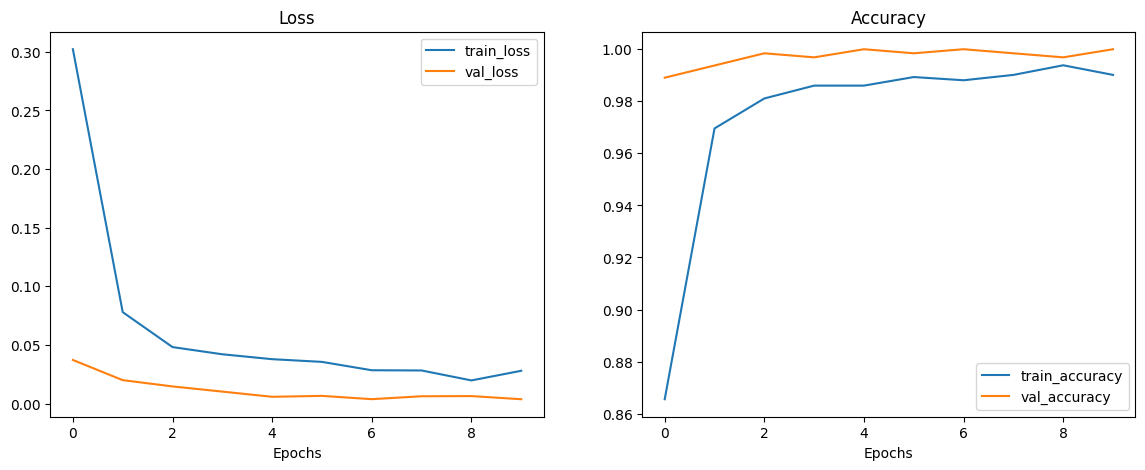

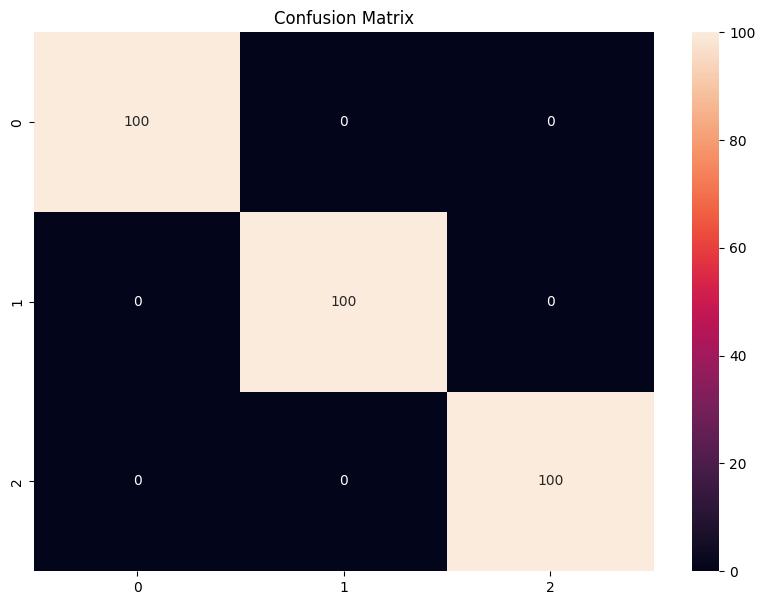

In [6]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': batch_size,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'sgd',
                'learning_rate': 0.01,
                'momentum': 0.8,
                'weight_decay': 0,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

# Add weight decay

## SGD

Device: 'cuda'
Epoch:  1 | Train Loss: 0.30250 | Train Acc: 86.6776 | Val Loss: 0.03478 | Val Acc: 99.0625
Epoch:  2 | Train Loss: 0.07983 | Train Acc: 97.0395 | Val Loss: 0.02756 | Val Acc: 98.9062
Epoch:  3 | Train Loss: 0.04922 | Train Acc: 98.2319 | Val Loss: 0.01144 | Val Acc: 99.8438
Epoch:  4 | Train Loss: 0.04153 | Train Acc: 98.6842 | Val Loss: 0.00924 | Val Acc: 99.6875
Epoch:  5 | Train Loss: 0.03498 | Train Acc: 98.6842 | Val Loss: 0.00628 | Val Acc: 100.0000
Epoch:  6 | Train Loss: 0.03603 | Train Acc: 98.9720 | Val Loss: 0.00804 | Val Acc: 99.6875
Epoch:  7 | Train Loss: 0.02539 | Train Acc: 99.0954 | Val Loss: 0.00605 | Val Acc: 99.8438
Epoch:  8 | Train Loss: 0.02650 | Train Acc: 99.3421 | Val Loss: 0.00571 | Val Acc: 99.6875
Epoch:  9 | Train Loss: 0.02362 | Train Acc: 99.2188 | Val Loss: 0.00758 | Val Acc: 99.6875
Epoch: 10 | Train Loss: 0.01796 | Train Acc: 99.3421 | Val Loss: 0.00433 | Val Acc: 99.8438



[INFO] Saving model to: runs\classify\train16

Time: 84.99s.


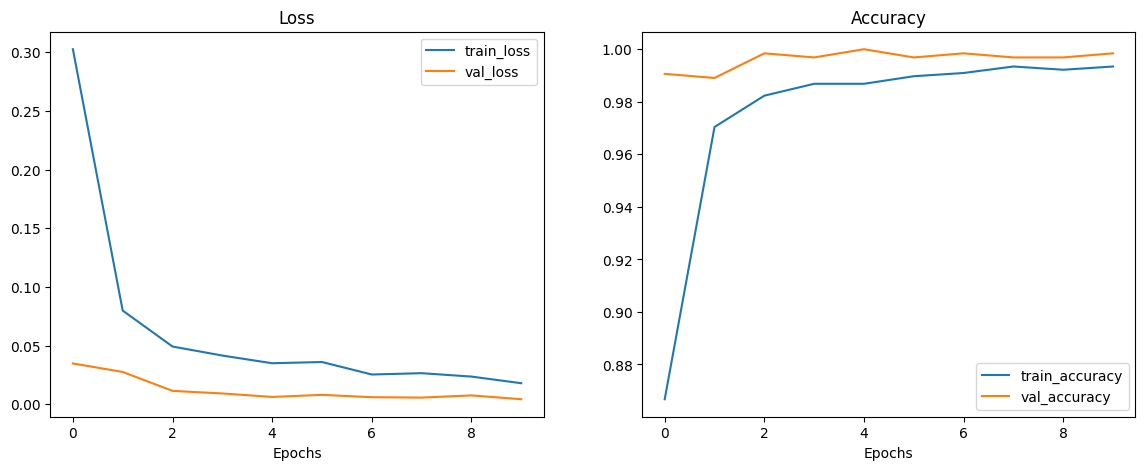

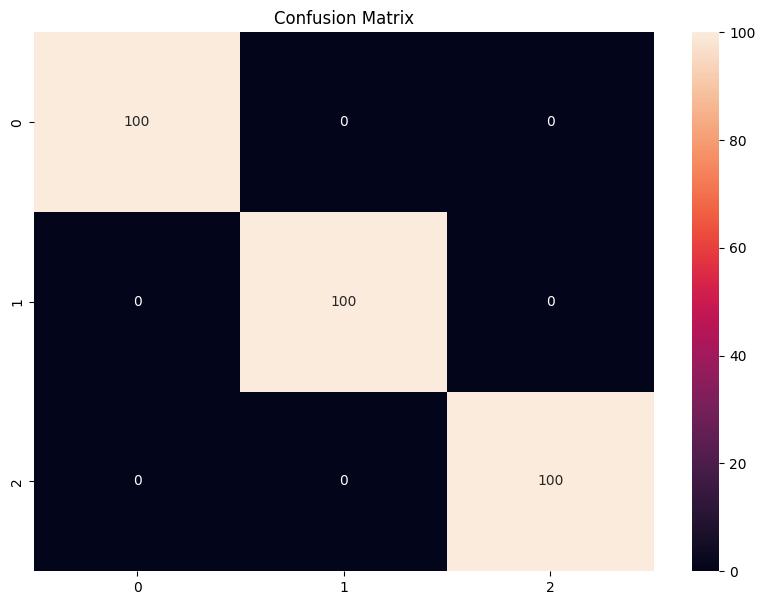

In [7]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': batch_size,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'sgd',
                'learning_rate': 0.01,
                'momentum': 0.8,
                'weight_decay': 0.001,
            },
            'lr_scheduler' : {
                'step_size' : 4,
                'gamma' : 1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

## Adam

Device: 'cuda'
Epoch:  1 | Train Loss: 0.29011 | Train Acc: 89.0625 | Val Loss: 0.05510 | Val Acc: 97.6562
Epoch:  2 | Train Loss: 0.17017 | Train Acc: 93.3799 | Val Loss: 0.13902 | Val Acc: 94.8438
Epoch:  3 | Train Loss: 0.08738 | Train Acc: 96.7105 | Val Loss: 0.03749 | Val Acc: 98.9062
Epoch:  4 | Train Loss: 0.07983 | Train Acc: 97.7796 | Val Loss: 0.08266 | Val Acc: 97.7083
Epoch:  5 | Train Loss: 0.11969 | Train Acc: 95.7237 | Val Loss: 0.23829 | Val Acc: 88.4375
Epoch:  6 | Train Loss: 0.11482 | Train Acc: 95.4770 | Val Loss: 0.05481 | Val Acc: 97.9688
Epoch:  7 | Train Loss: 0.10017 | Train Acc: 96.5461 | Val Loss: 0.03559 | Val Acc: 100.0000
Epoch:  8 | Train Loss: 0.08636 | Train Acc: 97.0806 | Val Loss: 0.04300 | Val Acc: 98.9062
Epoch:  9 | Train Loss: 0.08012 | Train Acc: 97.0806 | Val Loss: 0.04575 | Val Acc: 98.5938
Epoch: 10 | Train Loss: 0.07212 | Train Acc: 97.4507 | Val Loss: 0.04808 | Val Acc: 98.7500



[INFO] Saving model to: runs\classify\train14

Time: 83.9s.



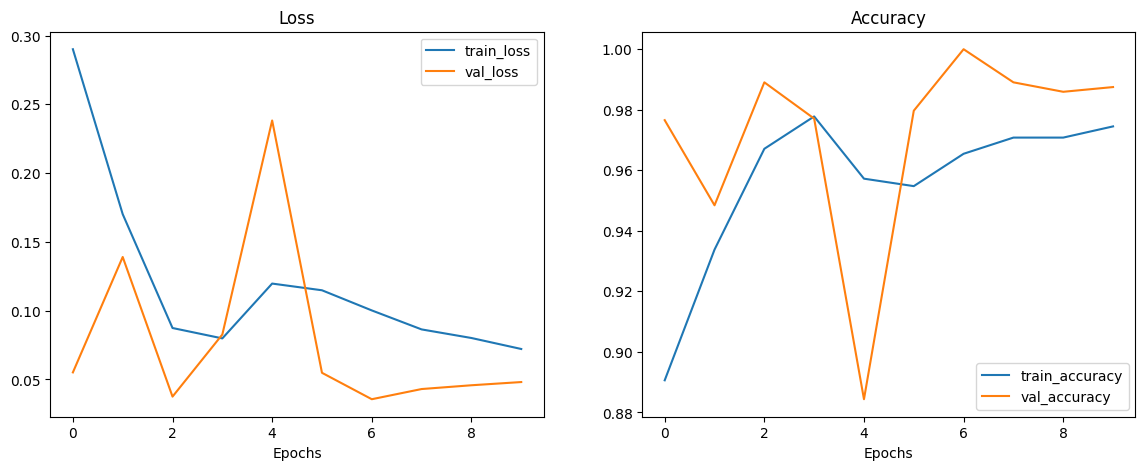

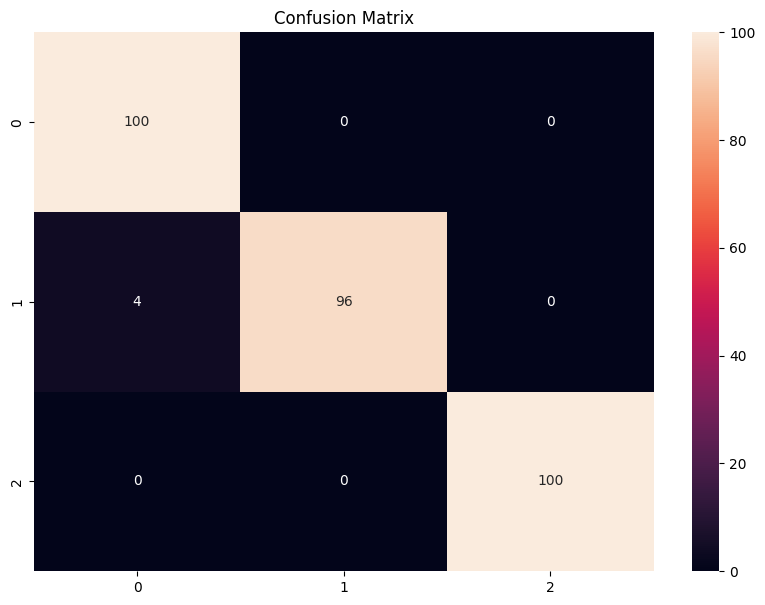

In [5]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': batch_size,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'adam',
                'learning_rate': 0.001,
                'momentum': None,
                'weight_decay': 0.001,
            },
            'lr_scheduler' : {
                'step_size' : 4,
                'gamma' : 1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

# Add learning rate decay

## SGD

Device: 'cuda'
Epoch:  1 | Train Loss: 0.30230 | Train Acc: 86.6365 | Val Loss: 0.03759 | Val Acc: 99.0625
Epoch:  2 | Train Loss: 0.08032 | Train Acc: 96.9984 | Val Loss: 0.02502 | Val Acc: 99.2188
Epoch:  3 | Train Loss: 0.04794 | Train Acc: 98.2319 | Val Loss: 0.01137 | Val Acc: 99.6875
Epoch:  4 | Train Loss: 0.04327 | Train Acc: 98.6020 | Val Loss: 0.00625 | Val Acc: 99.8438
Epoch:  5 | Train Loss: 0.03155 | Train Acc: 98.9720 | Val Loss: 0.00829 | Val Acc: 99.8438
Epoch:  6 | Train Loss: 0.03308 | Train Acc: 98.8076 | Val Loss: 0.00555 | Val Acc: 99.8438
Epoch:  7 | Train Loss: 0.02416 | Train Acc: 99.3010 | Val Loss: 0.00588 | Val Acc: 99.8438
Epoch:  8 | Train Loss: 0.02763 | Train Acc: 99.0543 | Val Loss: 0.00571 | Val Acc: 99.8438
Epoch:  9 | Train Loss: 0.01818 | Train Acc: 99.5066 | Val Loss: 0.00572 | Val Acc: 99.8438
Epoch: 10 | Train Loss: 0.01992 | Train Acc: 99.4243 | Val Loss: 0.00571 | Val Acc: 99.6875



[INFO] Saving model to: runs\classify\train17

Time: 84.96s.



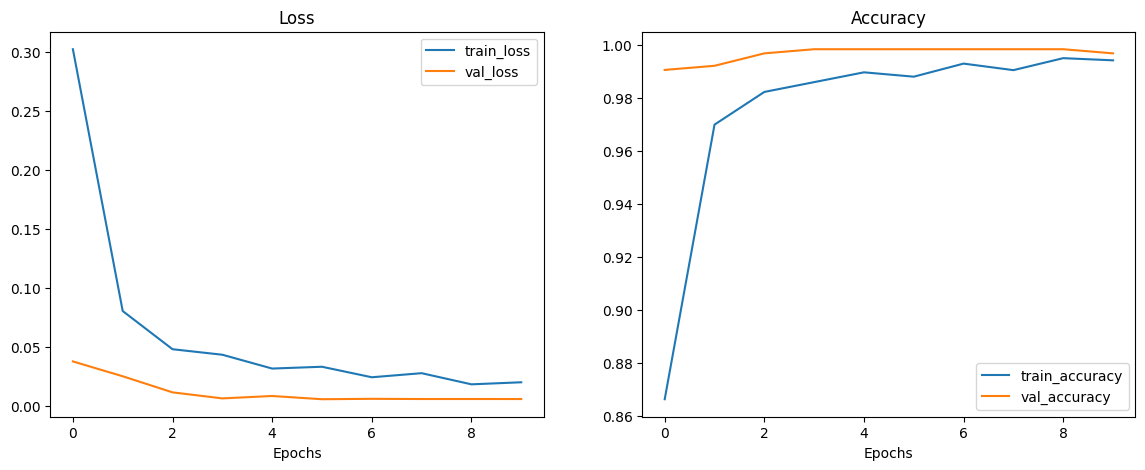

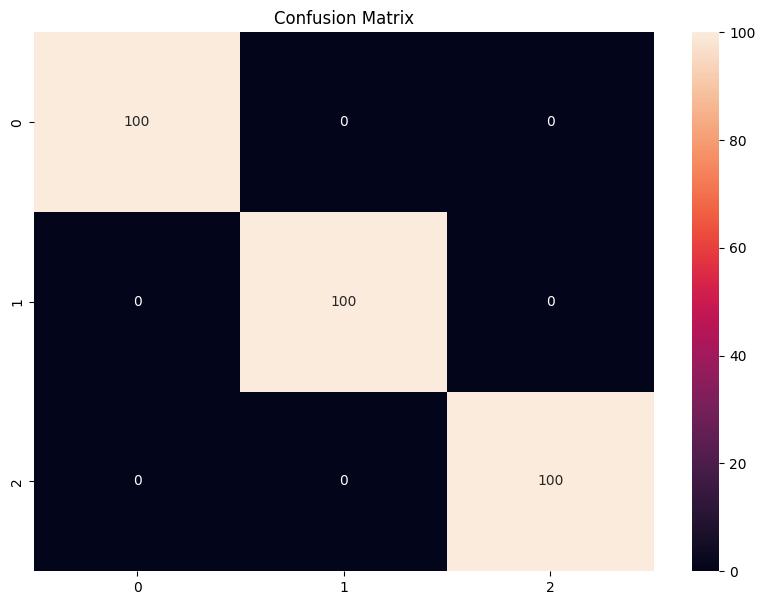

In [8]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': batch_size,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'sgd',
                'learning_rate': 0.01,
                'momentum': 0.8,
                'weight_decay': 0.001,
            },
            'lr_scheduler' : {
                'step_size' : 4,
                'gamma' : 0.1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

## Adam

Device: 'cuda'
Epoch:  1 | Train Loss: 0.29252 | Train Acc: 89.2270 | Val Loss: 0.57487 | Val Acc: 85.4688
Epoch:  2 | Train Loss: 0.15133 | Train Acc: 94.4901 | Val Loss: 0.07808 | Val Acc: 97.8125
Epoch:  3 | Train Loss: 0.10376 | Train Acc: 96.2171 | Val Loss: 0.12167 | Val Acc: 94.9479
Epoch:  4 | Train Loss: 0.10915 | Train Acc: 96.3816 | Val Loss: 0.07644 | Val Acc: 97.6562
Epoch:  5 | Train Loss: 0.07918 | Train Acc: 97.0395 | Val Loss: 0.01404 | Val Acc: 99.8438
Epoch:  6 | Train Loss: 0.05425 | Train Acc: 97.9852 | Val Loss: 0.01204 | Val Acc: 99.6875
Epoch:  7 | Train Loss: 0.03652 | Train Acc: 98.8076 | Val Loss: 0.00906 | Val Acc: 99.6875
Epoch:  8 | Train Loss: 0.03633 | Train Acc: 99.0543 | Val Loss: 0.00834 | Val Acc: 99.8438
Epoch:  9 | Train Loss: 0.03386 | Train Acc: 98.4786 | Val Loss: 0.01048 | Val Acc: 99.5312
Epoch: 10 | Train Loss: 0.02376 | Train Acc: 99.2599 | Val Loss: 0.00708 | Val Acc: 99.5312



[INFO] Saving model to: runs\classify\train12

Time: 86.78s.



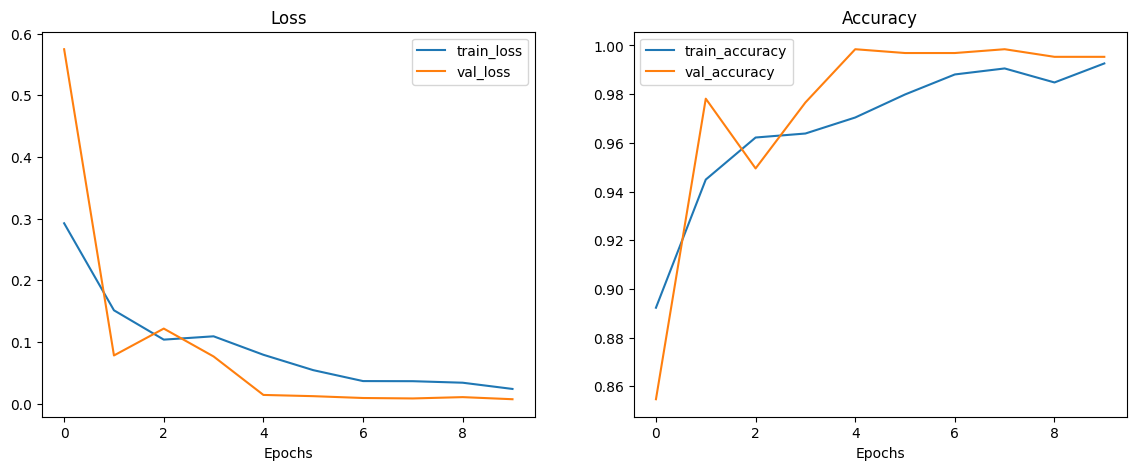

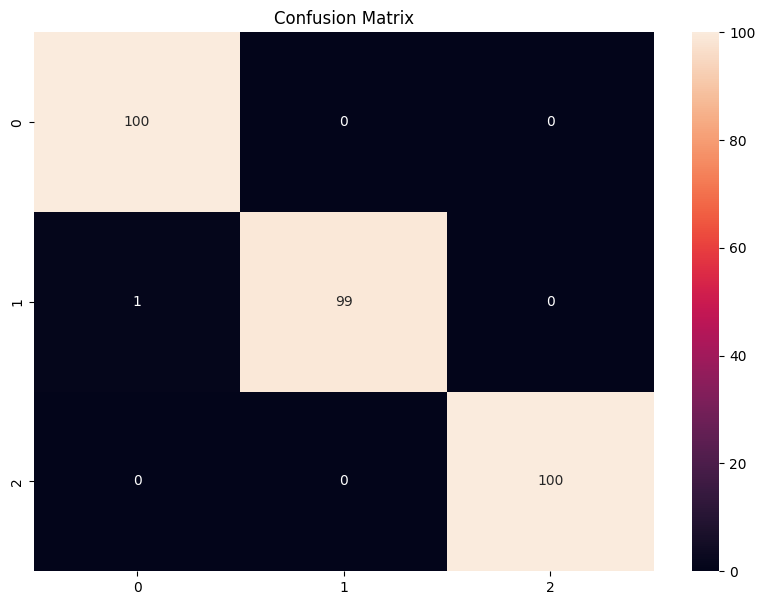

In [12]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato_scale_down',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': batch_size,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 10,
            'optimize' : {
                'optimizer': 'adam',
                'learning_rate': 0.001,
                'momentum': None,
                'weight_decay': 0.001,
            },
            'lr_scheduler' : {
                'step_size' : 4,
                'gamma' : 0.1,
            },
            'save_checkpoint_freq' : 0,
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)